# Load dataset

I download the dataset from : https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip

In [27]:
import os
from zipfile import ZipFile
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [28]:
with open("data_path.txt", "r") as f:
    data_path = f.read()

It is more common to load a dataset from an architecture were the directories containing the images represent the categories.
Let's reorganize our data as such:
* dog/
    * dog_1.jpg
    * dog_2.jpg
* cat/
    * cat_1.jpg
    * cat_2.jpg

In [29]:
def extract_images(data_path: str) -> None:
    """
    Takes images from zip file and split them between a cat and a dog directory.

    Arg:
        - data_path: path toward the parent directory of the zip file.
    """
    # Create the path toward the cat and dog directories.
    cat_dir = os.path.join(data_path, "cat")
    dog_dir = os.path.join(data_path, "dog")

    # Open the zip file
    zip_path = os.path.join(data_path, "train.zip")
    with ZipFile(zip_path, "r") as myzip:
        # Use tqdm to have a progress bar while looping on images.
        for name in tqdm(myzip.namelist()):
            # Check that the file is an image
            if name.endswith("jpg"):
                # Extract image from zip file
                if "cat" in name:
                    myzip.extract(name, path=cat_dir)
                    source = os.path.join(cat_dir, name)
                    
                if "dog" in name:
                    myzip.extract(name, path=dog_dir)
                    source = os.path.join(dog_dir, name)
                
                # Move the image to destination directory.
                dest = source.replace("train/", "")
                os.rename(source, dest)

In [30]:
# I chose skimage because it is made by sci-kit learn contributors 
# and I am gonna be using sci-kit learn all throughout this notebook. 
# Moreover, this module was build on top of OpenCV to make it easier to use.
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist

In [31]:
def preprocessing(img_path: str, grayscale: bool=True, size: tuple=(64,64), equalize: bool=True) -> np.ndarray:
    """
    The image preprocessing steps before fitting the model.

    Args:
        - img_path: image path.
        - grayscale: if true, convert image from RGB to grayscale.
        - size: width and length to resize the image with.
        - equalize: if true then equalize image histogram, else not.
    
    Returns:
        The preprocessed image as a numpy array.
    """
    img = imread(img_path)
    img = resize(img, size)
    
    if grayscale:
        img = rgb2gray(img)
    
    if equalize:
        img = equalize_hist(img)
    return img


def load_preprocess_dataset(data_path: str, img_number: int, grayscale: bool=True, size: tuple=(64,64), equalize: bool=True) -> tuple:
    """
    Load and preprocess the collection of images.

    Args:
        - data_path: path toward the parent directory of the zip file.
        - img_number: number of images to include in the collection. If 0, then the whole collection is loaded.
        - grayscale: if true, convert image from RGB to grayscale.
        - size: width and length to resize the image with.
        - equalize: if true then equalize image histogram, else not.
    
    Returns:
        The collection of preprocess images as a list of numpy arrays and a list of labels.
    """
    cat_dir_path = os.path.join(data_path, "cat")
    dog_dir_path = os.path.join(data_path, "dog")

    cat_img_paths = [os.path.join(root, path) for root, dirs, files in os.walk(cat_dir_path) for path in files]
    dog_img_paths = [os.path.join(root, path) for root, dirs, files in os.walk(dog_dir_path) for path in files]

    if img_number:
        cat_img_paths = cat_img_paths[:img_number]
        dog_img_paths = dog_img_paths[:img_number]

    img_paths = cat_img_paths + dog_img_paths
    labels = [0] * len(cat_img_paths) + [1] * len(dog_img_paths)

    return ([preprocessing(img_path, grayscale, size, equalize) for img_path in img_paths], labels)

We thus included 3 parameters in our preprocessing: grayscale, resizing and histogram equalization.

We cannot assume that they automatically will improve our classification. We need to test them out.

In [32]:
dataset_name = os.path.join(data_path, "cat")

# Detect of the cat directory exists. 
# If not, then extract images from zip file.
if not os.path.exists(dataset_name):
    extract_images(data_path)

In [33]:
# Let's use a subset of 200 images (100 per class) to test our code.
images, labels = load_preprocess_dataset(data_path, 100, False, (224,224))

/home/quillaur/streamlit_apps/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


# Visualisation

Always visualize some samples before moving on.

In [34]:
import matplotlib.pyplot as plt

In [35]:
def plot_images(images: list, labels: list, num: int):
    """
    Visualise the wanted number of images and labels.

    Args:
        - images: list of numpy arrays containing image pixels.
        - labels: lise of labels.
        - num: the number of images to visualize.
    """
    # Set the figure parameters based on the number of images.
    fig, axes = plt.subplots(1, num, figsize=(num*3, 4))
    ax = axes.ravel()

    for i in range(num):
        ax[i].set_title(labels[i])
        ax[i].imshow(images[i], cmap=plt.cm.gray)

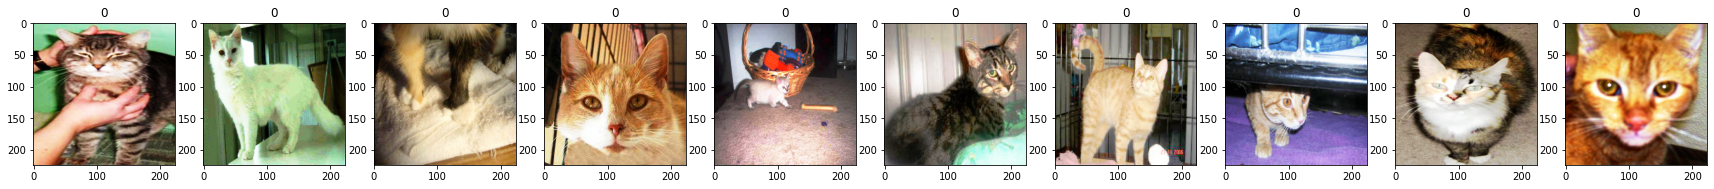

In [36]:
plot_images(images, labels, 10)

# Exploration

In [37]:
X = np.array(images).reshape(len(images),-1)
y = np.array(labels)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    shuffle=True,
    random_state=42,
)

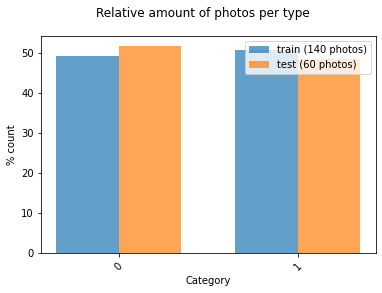

In [39]:
def plot_bar(y: list, loc: str='left', relative: bool=True) -> None:
    """
    Found this function to automatically visualize the balance between train and test images number for each category.
    I saddly lost the link toward the reference that got me this code...
    """
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('Category')
    plt.ylabel(ylabel_text)
 
plt.suptitle('Relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
])

# Model selection

Let's stay on common machine learning models from various families while testing both linear and non-linear models.

In [40]:
# Import the models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Always use cross validation to test your models.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from statistics import mean, stdev

# Let's do a random selection of preprocessing parameters
import random
# The time module will help us monitor model trainings.
import time

In [41]:
def train_test_model(model, images, labels) -> tuple:
    """
    Upon training the model, monitor the training time 
    and test accuracy with cross-validation.
    """
    X = np.array(images).reshape(len(images),-1)
    y = np.array(labels)
    # Split le dataset
    X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    shuffle=True,
    random_state=42,
    )
    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    # Test
    accuracies = cross_val_score(model, X_test, y_test, cv=5)
    model_accuracy = mean(accuracies)
    
    return (model, model_accuracy, stdev(accuracies), training_time)



def test_models(models: dict, data_path: str, preprocess_params: list, n_iter: int) -> pd.DataFrame:
    tested_gray = []
    tested_sizes = []
    tested_equal = []
    tested_models = []
    training_times = []
    scores = []
    deviations = []
    for _ in tqdm(range(n_iter)):
        # Select randomly the parameters
        grayscale, size, equalize = [random.choice(params) for params in preprocess_params]
        size = (size, size) # Use same size for width and length
        # Load the data with selected parameters.
        images, labels = load_preprocess_dataset(data_path, 100, grayscale, size, equalize)
        # Train and test the models.
        for name, model in models.items():
            # Keep track of what is being tested
            tested_gray.append(grayscale)
            tested_sizes.append(size)
            tested_equal.append(equalize)
            tested_models.append(name)

            # Train and test
            model, model_accuracy, training_time, deviation = train_test_model(model, images, labels)

            # Track success
            scores.append(model_accuracy)
            deviations.append(deviation)
            training_times.append(training_time)

    return pd.DataFrame({
        "model": tested_models,
        "grayscale": tested_gray,
        "size": tested_sizes,
        "equalize histogram": tested_equal,
        "Accuracy": scores,
        "Stdev": deviations,
        "Training time": training_times
    })

In [42]:
models = {
    "knn": KNeighborsClassifier(),
    "logreg": LogisticRegression(),
    "svc": SVC(),
    "RFC": RandomForestClassifier(),
    # "GBC": GradientBoostingClassifier(),
    # "MLP": MLPClassifier()
}

So we selected 4 models to test, but we also said earlier that we have 3 preprocessing parameters to test.

Let's layout the full testing protocol then.

In [43]:
preprocess_params = [
    [True, False], # grayscale
    [32,64,128,224], # size
    [True, False] # equalize histogram
]

training_results = test_models(models, data_path, preprocess_params, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/quillaur/streamlit_apps/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/quillaur/streamlit_apps/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

# Performances

In [44]:
training_results.sort_values(by="Accuracy", ascending=False, axis=0, inplace=True)
training_results

,model,grayscale,size,equalize histogram,Accuracy,Stdev,Training time
39,RFC,False,"(32, 32)",False,0.566667,0.444189,0.069722
9,logreg,True,"(224, 224)",True,0.566667,5.128927,0.108653
5,logreg,True,"(32, 32)",True,0.533333,0.067281,0.200693
29,logreg,False,"(224, 224)",True,0.533333,11.338246,0.151383
23,RFC,False,"(224, 224)",False,0.533333,1.512293,0.074536
2,svc,True,"(64, 64)",False,0.516667,0.047654,0.108653
15,RFC,False,"(64, 64)",False,0.516667,0.745928,0.069722
3,RFC,True,"(64, 64)",False,0.500000,0.252106,0.131762
14,svc,False,"(64, 64)",False,0.483333,0.681950,0.069722
19,RFC,False,"(224, 224)",False,0.483333,1.840798,0.069722


No matter what, the performances are poor. Looks like the preprocessing is what has the most impact on the accuracy with a slight advantage for RFC and logistic regression in the top scorer.

In [45]:
# Select best working model and preprocess params.
best_model, grayscale, size, equalize, acc, std, train_time = training_results.iloc[0]
print(f"The best results are obtained with: {best_model}, grayscale = {grayscale}, size = {size}, equalizing histogram = {equalize}.")

The best results are obtained with: RFC, grayscale = False, size = (32, 32), equalizing histogram = False.


In [46]:
img_num = 1000
images, labels = load_preprocess_dataset(data_path, img_num, grayscale, size, equalize)

In [47]:
best_model = models[best_model]
best_model, model_accuracy, training_time, deviation = train_test_model(best_model, images, labels)

In [48]:
print(f"{best_model} : {model_accuracy} accuracy for {train_time} seconds of training with {img_num} images.")

RandomForestClassifier() : 0.6016666666666667 accuracy for 0.06972166887783962 seconds of training with 1000 images.


In [49]:
X = np.array(images).reshape(len(images),-1)
y = np.array(labels)
# Split le dataset
X_train, X_test, y_train, y_test = train_test_split(
X, 
y, 
test_size=0.3, 
shuffle=True,
random_state=42,
)
y_true = y_test
y_pred = best_model.predict(X_test)

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true, y_pred, target_names=["dog", "cat"]))

              precision    recall  f1-score   support

         dog       0.63      0.67      0.65       302
         cat       0.64      0.61      0.63       298

    accuracy                           0.64       600
   macro avg       0.64      0.64      0.64       600
weighted avg       0.64      0.64      0.64       600



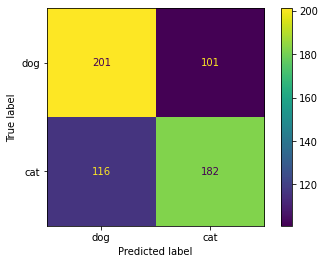

In [51]:
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["dog", "cat"])
cmd.plot()
plt.show()

Confusion matrix clearly shows that the model is... confused ! Making as much misstake in the FP and FN while being only slightly better on TP and TN.

# References

* https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
* https://scikit-image.org/
* https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-les-bases-de-traitement-dimages-avec-scikit-image